In [1]:
import os 
import pandas as pd 
from openai import OpenAI
import random
import numpy as np

## set global random seed
RANDOM_SEED = 62

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)



In [2]:
## load data
df = pd.read_csv("sofmattress_train.csv")
df.head()

,sentence,label
0,You guys provide EMI option?,EMI
1,Do you offer Zero Percent EMI payment options?,EMI
2,0% EMI.,EMI
3,EMI,EMI
4,I want in installment,EMI


In [3]:
df["label"].value_counts()


label
DISTRIBUTORS             34
EMI                      25
MATTRESS_COST            22
LEAD_GEN                 21
PRODUCT_VARIANTS         21
ORDER_STATUS             21
WHAT_SIZE_TO_ORDER       20
100_NIGHT_TRIAL_OFFER    18
ORTHO_FEATURES           17
RETURN_EXCHANGE          14
COD                      12
COMPARISON               11
ERGO_FEATURES            11
ABOUT_SOF_MATTRESS       11
DELAY_IN_DELIVERY        11
CANCEL_ORDER             10
PILLOWS                  10
CHECK_PINCODE            10
WARRANTY                 10
OFFERS                   10
SIZE_CUSTOMIZATION        9
Name: count, dtype: int64

In [4]:
df["label"].value_counts(normalize=True)

label
DISTRIBUTORS             0.103659
EMI                      0.076220
MATTRESS_COST            0.067073
LEAD_GEN                 0.064024
PRODUCT_VARIANTS         0.064024
ORDER_STATUS             0.064024
WHAT_SIZE_TO_ORDER       0.060976
100_NIGHT_TRIAL_OFFER    0.054878
ORTHO_FEATURES           0.051829
RETURN_EXCHANGE          0.042683
COD                      0.036585
COMPARISON               0.033537
ERGO_FEATURES            0.033537
ABOUT_SOF_MATTRESS       0.033537
DELAY_IN_DELIVERY        0.033537
CANCEL_ORDER             0.030488
PILLOWS                  0.030488
CHECK_PINCODE            0.030488
WARRANTY                 0.030488
OFFERS                   0.030488
SIZE_CUSTOMIZATION       0.027439
Name: proportion, dtype: float64

In [5]:
## baseline -> tf-idf + logistic regression, tf-idf + xgboost

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score


# Convert labels to numeric
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["label_encoded"] = le.fit_transform(df["label"])

# Set up TF-IDF
vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1, 2))

# Prepare data
texts = df["sentence"].values
labels = df["label_encoded"].values

# Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)

logreg_scores = []
xgb_scores = []

print("\n===== Cross-Validation Results =====")
for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels)):
    print(f"\nFold {fold + 1}")

    # Split data
    X_train, X_val = texts[train_idx], texts[val_idx]
    y_train, y_val = labels[train_idx], labels[val_idx]

    # Fit TF-IDF on train, transform both
    X_train_vec = vectorizer.fit_transform(X_train)
    X_val_vec = vectorizer.transform(X_val)

    # ---- Logistic Regression ----
    logreg = LogisticRegression(class_weight='balanced', max_iter=1000)
    logreg.fit(X_train_vec, y_train)
    y_pred_lr = logreg.predict(X_val_vec)
    score_lr = f1_score(y_val, y_pred_lr, average='macro')
    logreg_scores.append(score_lr)
    print(f"Logistic Regression F1 (macro): {score_lr:.4f}")

    # ---- XGBoost ----
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    xgb.fit(X_train_vec, y_train)
    y_pred_xgb = xgb.predict(X_val_vec)
    score_xgb = f1_score(y_val, y_pred_xgb, average='macro')
    xgb_scores.append(score_xgb)
    print(f"XGBoost F1 (macro): {score_xgb:.4f}")

# Summary
print("\n===== Average Scores =====")
print(f"Logistic Regression avg F1 (macro): {np.mean(logreg_scores):.4f}")
print(f"XGBoost avg F1 (macro): {np.mean(xgb_scores):.4f}")



===== Cross-Validation Results =====

Fold 1
Logistic Regression F1 (macro): 0.8585


/Users/sadivamadaan/Downloads/Tifin_Test_1/data/tifin/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:35:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost F1 (macro): 0.5812

Fold 2
Logistic Regression F1 (macro): 0.7928


/Users/sadivamadaan/Downloads/Tifin_Test_1/data/tifin/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:35:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost F1 (macro): 0.6483

Fold 3
Logistic Regression F1 (macro): 0.7474


/Users/sadivamadaan/Downloads/Tifin_Test_1/data/tifin/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:35:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost F1 (macro): 0.5329

Fold 4
Logistic Regression F1 (macro): 0.8336


/Users/sadivamadaan/Downloads/Tifin_Test_1/data/tifin/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:35:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost F1 (macro): 0.6398

Fold 5
Logistic Regression F1 (macro): 0.7593


/Users/sadivamadaan/Downloads/Tifin_Test_1/data/tifin/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:35:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost F1 (macro): 0.5742

===== Average Scores =====
Logistic Regression avg F1 (macro): 0.7983
XGBoost avg F1 (macro): 0.5953


In [6]:
import openai
from tqdm import tqdm

# === Replace with your OpenAI key ===
openai.api_key = "sk-svcacct-XoDm82FIvbsPpvMa1cHNvQ6jHvCKZ-x6pERpSKy68fspNGVPewiDjtSZkC1ge75gXalT3BlbkFJhmLZ82yo42HAo2sP3mkiwV8crramxS7FkX63xI1w7PvBehiBTphZGHD7xHOVMveVJEgA"

labels = df['label'].astype('category').cat.codes  

# === Helper function to get embeddings ===
def get_openai_embeddings(texts, model="text-embedding-3-small", batch_size=20):
    all_embeddings = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        response = openai.embeddings.create(input=batch, model=model)
        embeddings = [d.embedding for d in response.data]
        all_embeddings.extend(embeddings)
    return np.array(all_embeddings)

# === Get or load embeddings ===
try:
    X = np.load("openai_embeddings.npy")
except:
    X = get_openai_embeddings(texts)
    np.save("openai_embeddings.npy", X)

y = labels.values

# === Stratified K-Fold Cross Validation ===
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)

f1_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    clf = LogisticRegression(max_iter=1000, class_weight="balanced")
    clf.fit(X_train, y_train)
    
    preds = clf.predict(X_val)
    f1 = f1_score(y_val, preds, average='macro')
    print(f"Fold {fold} - F1 Macro: {f1:.4f}")
    f1_scores.append(f1)

print(f"\n✅ Average F1 Macro: {np.mean(f1_scores):.4f}")


Fold 1 - F1 Macro: 0.9148
Fold 2 - F1 Macro: 0.8547
Fold 3 - F1 Macro: 0.8639
Fold 4 - F1 Macro: 0.8983
Fold 5 - F1 Macro: 0.9330

✅ Average F1 Macro: 0.8929


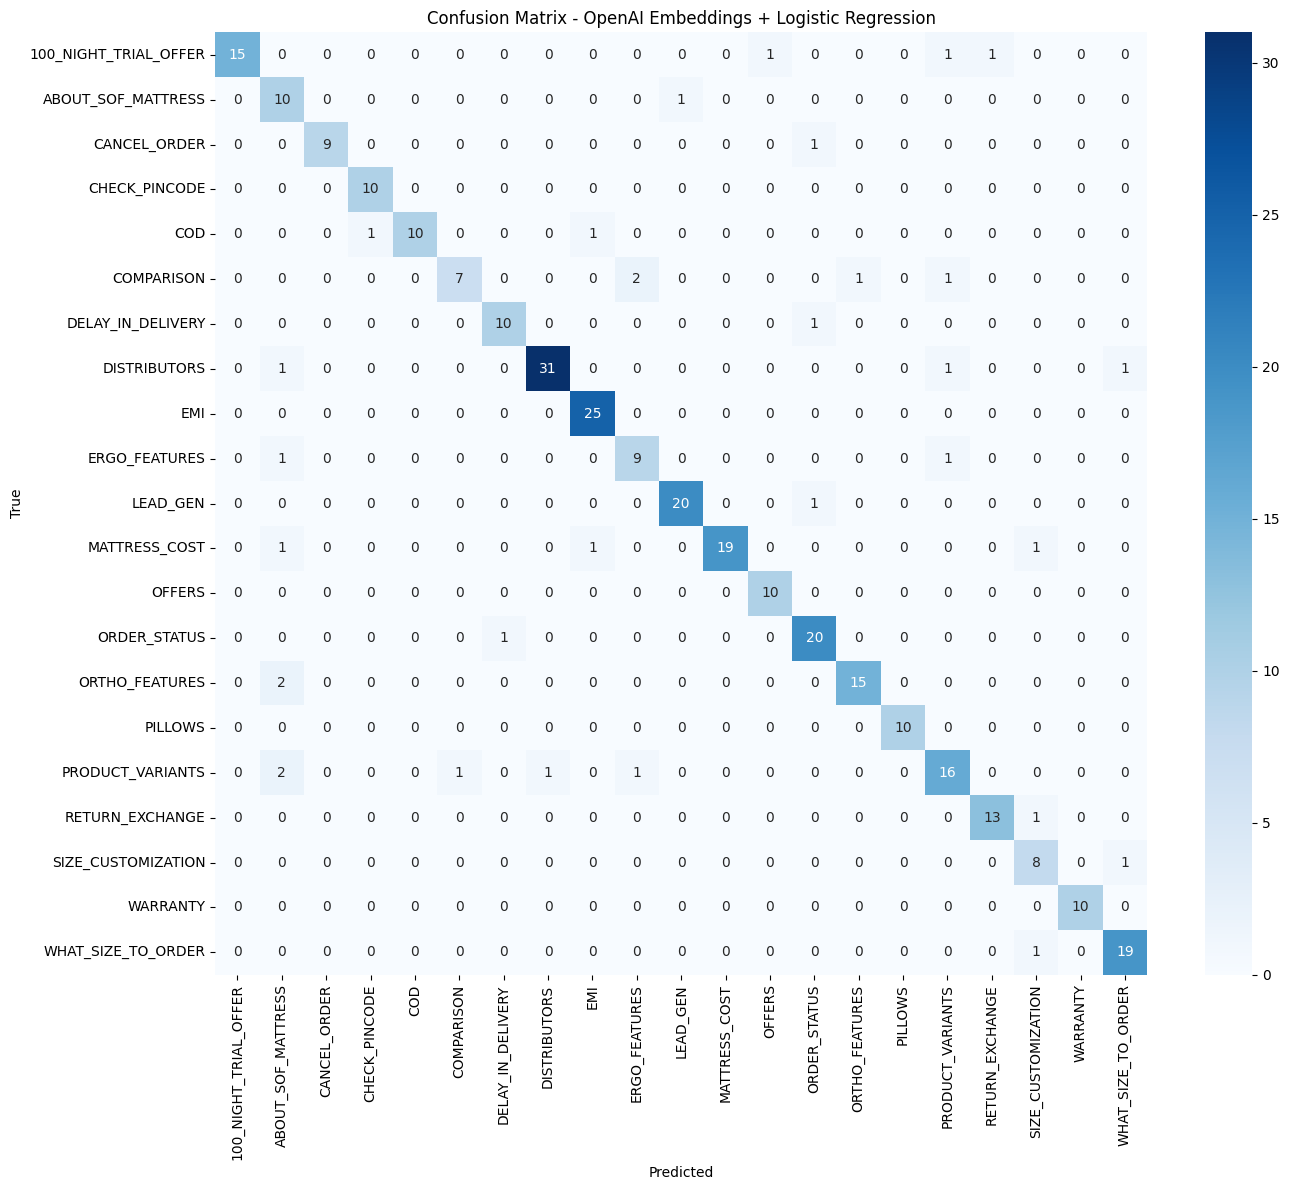


🔍 Classification Report:
                       precision    recall  f1-score   support

100_NIGHT_TRIAL_OFFER      1.000     0.833     0.909        18
   ABOUT_SOF_MATTRESS      0.588     0.909     0.714        11
         CANCEL_ORDER      1.000     0.900     0.947        10
        CHECK_PINCODE      0.909     1.000     0.952        10
                  COD      1.000     0.833     0.909        12
           COMPARISON      0.875     0.636     0.737        11
    DELAY_IN_DELIVERY      0.909     0.909     0.909        11
         DISTRIBUTORS      0.969     0.912     0.939        34
                  EMI      0.926     1.000     0.962        25
        ERGO_FEATURES      0.750     0.818     0.783        11
             LEAD_GEN      0.952     0.952     0.952        21
        MATTRESS_COST      1.000     0.864     0.927        22
               OFFERS      0.909     1.000     0.952        10
         ORDER_STATUS      0.870     0.952     0.909        21
       ORTHO_FEATURES      0

In [7]:
### Error Analysis

from sklearn.metrics import f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# === Load your dataset ===

label_encoder = df['label'].astype('category')
labels = label_encoder.cat.codes
label_names = label_encoder.cat.categories.tolist()



try:
    X = np.load("openai_embeddings.npy")
except:
    X = get_openai_embeddings(texts)
    np.save("openai_embeddings.npy", X)

y = labels.values

# === Stratified K-Fold + Collecting Predictions for Confusion Matrix ===
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)

y_true_all = []
y_pred_all = []

for train_idx, val_idx in skf.split(X, y):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    clf = LogisticRegression(max_iter=1000, class_weight="balanced")
    clf.fit(X_train, y_train)

    preds = clf.predict(X_val)

    y_true_all.extend(y_val)
    y_pred_all.extend(preds)

# === Confusion Matrix ===
cm = confusion_matrix(y_true_all, y_pred_all)
plt.figure(figsize=(14, 12))
sns.heatmap(cm, xticklabels=label_names, yticklabels=label_names,
            annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - OpenAI Embeddings + Logistic Regression")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# === Classification Report for per-label F1 ===
report = classification_report(y_true_all, y_pred_all, target_names=label_names, digits=3)
print("\n🔍 Classification Report:")
print(report)


In [16]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, Dataset
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Load the MiniLM v6 model and tokenizer from Hugging Face
model_name = "distilbert-base-uncased"

# Initialize tokenizer and model


tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=df["label"].nunique())

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=100)

train_df.drop(columns = ["label"], axis = 1, inplace = True)
val_df.drop(columns = ["label"], axis = 1, inplace = True)
train_df.rename(columns = {"label_encoded": "label"}, inplace = True)
val_df.rename(columns = {"label_encoded": "label"}, inplace = True)


train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(val_df)

# Tokenize the datasets
def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
eval_dataset = eval_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
eval_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Define a custom compute_metrics function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    f1 = f1_score(labels, preds, average='macro')
    accuracy = accuracy_score(labels, preds)
    return {"accuracy": accuracy, "f1_macro": f1}

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",  # Output directory for model checkpoints
    eval_strategy="epoch",  # Evaluate after each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=8,  # Adjust based on available memory
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs",  # Directory for logs
    logging_steps=10,
    save_strategy="epoch",  # Save model checkpoint every 500 steps
    load_best_model_at_end=True,  # Load the best model based on evaluation
    report_to="none",  # Disable reporting to external services like wandb
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")


Using device: mps


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/262 [00:00<?, ? examples/s]

Map:   0%|          | 0/66 [00:00<?, ? examples/s]

/var/folders/l3/tmswb2bs135240wb51dlgl3w0000gn/T/ipykernel_10158/71660183.py:65: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,3.042200,2.966183,0.196970,0.083401
2,2.798300,2.679343,0.378788,0.288773
3,2.500500,2.371054,0.651515,0.551582
4,2.178700,2.081453,0.712121,0.589661
5,1.932200,1.859301,0.727273,0.592342
6,1.690500,1.670092,0.757576,0.644388
7,1.528300,1.539665,0.757576,0.647274
8,1.421900,1.447705,0.772727,0.677962
9,1.336500,1.389586,0.772727,0.677962
10,1.169600,1.372363,0.772727,0.677962


Evaluation results: {'eval_loss': 1.3723628520965576, 'eval_accuracy': 0.7727272727272727, 'eval_f1_macro': 0.6779615886758744, 'eval_runtime': 2.2552, 'eval_samples_per_second': 29.266, 'eval_steps_per_second': 3.991, 'epoch': 10.0}


In [14]:
train_df

,sentence,label
117,Length,20
62,What is responsive foam,9
86,How does the 100 night trial work,0
225,What are the SOF mattress products,16
81,Tell me about the product warranty,19
...,...,...
5,I want it on 0% interest,8
90,100 night trial,0
316,Can I also have pillows,15
142,I want to buy this,10
